### Split dentex quadrant data into train, val, test sets ###

In [215]:
import os
import numpy as np
import pandas as pd
import glob
import json
import copy
import random
from pathlib import Path
import logging
import itertools
from PIL import Image
import datetime
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import patches

logger = logging.getLogger(name=__name__)

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import detection as dt
from detection.dentexdata import DentexData, fdi_ada_mapping, val_test_split
from detection.fileutils import FileOP
from detection.imageproc import ImageData, xywh2xyxy, xyxy2xywh, clipxywh

print(f'Project module version: {dt.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project module version: 0.0.1.post1.dev16+g367a5b6


### Define data locations for this notebook ###

In [99]:
# Data directory
data_root = os.path.join(os.environ.get('HOME'), 'data')
data_dir = os.path.join(data_root, 'dentex_detection')
model_dir = os.path.join(data_dir, 'model')

# Image directory (after cropping the data)
image_dir = os.path.join(data_dir, 'quadrants')

# Output directory to save examples
output_dir = os.path.join(data_dir, 'output')
Path(output_dir).mkdir(exist_ok=True, parents=True)

### Make sure that the data is available ###

In [6]:
# Check the images on disk
file_list = glob.glob(os.path.join(image_dir, '*.png'))
expected_n_images = 2531
if not len(file_list) == expected_n_images:
    print(f'WARNING: expected number of images ({expected_n_images}) does not match the number of images on disk.')
    print(f'Delete files and start over.')
else:
    print(f'Found {len(file_list)} images.')

Found 2531 images.


### Functions ###

In [130]:
# Create a function to show an image with bounding boxes
def show_image_with_boxes(image, box_list, label_list=None, alpha=0.7, edgecolor=None, ax=None):
    color = plt.cm.rainbow(np.linspace(0, 1, len(box_list)))
    color_list = [color[c] for c in range(len(color))]
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    for b, box in enumerate(box_list):
        if edgecolor is None:
            boxcolor = color_list[b]
        else:
            boxcolor = edgecolor
        anchor = (box[0], box[1])
        width = box[2]
        height = box[3]
        #anchor, width, height = rectangle(box)
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=2.5, 
                                 edgecolor=boxcolor, 
                                 facecolor='none', 
                                 alpha=alpha)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=anchor[0]+width/2, y=anchor[1]-3, s=label_list[b], color=boxcolor)
    ax.set(xticks=[], yticks=[])
    return ax

# Create a function to show an image with segmentations
def show_image_with_segmentations(image, segmentation_list, label_list=None, alpha=0.7, edgecolor=None, ax=None):
    # Convert list of segmentations to arrays (N, 2)
    segmentation_edges_list = [segmentation_edges(seg[0]) for seg in segmentation_list]
    color = plt.cm.rainbow(np.linspace(0, 1, len(segmentation_list)))
    color_list = [color[c] for c in range(len(color))]
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    for s, seg in enumerate(segmentation_edges_list):
        if edgecolor is None:
            seg_color = color_list[s]
        else:
            seg_color = edgecolor
        anchor = (min(seg[:, 0]), min(seg[:, 1]))
        contour = patches.Polygon(xy=seg, 
                                  linewidth=1.5, 
                                  edgecolor=seg_color,
                                  facecolor=seg_color, 
                                  alpha=0.5)
        ax.add_patch(contour)
        if label_list is not None:
            ax.text(x=anchor[0], y=anchor[1], s=label_list[s], 
                    color=seg_color, fontsize=30)
    ax.set(xticks=[], yticks=[])
    return ax

# Flatten list of lists
def flatten(list_of_lists):
    return list(itertools.chain.from_iterable(list_of_lists))

# Create a function to build (x, y) tuples from segmentation lists
def segmentation_edges(segmentation: list) -> np.ndarray:
    output = None
    try:
        assert isinstance(segmentation, list)
        assert isinstance(segmentation[0], (int, np.int64))
        assert len(segmentation) % 2 == 0
    except AssertionError as e:
        logger.error('segmentation must be a flat even-lenth list of integer values')
    else:
        seg_x = [segmentation[i] for i in range(len(segmentation)) if i % 2 == 0]
        seg_y = [segmentation[i] for i in range(len(segmentation)) if i % 2 == 1]
        output = np.array(list(zip(seg_x, seg_y)))
    return output

# Category mapping
fdi2ada  = fdi_ada_mapping()
ada2fdi = {v: k for k, v in fdi2ada.items()}

# Quick histogram to show distribution of teeth
def plot_hist(data, ax):
    plt.style.use('default')
    g = sns.histplot(data=data, x='ada', hue='quadrant', 
                     ax=ax, palette='Blues', 
                     discrete=True)
    sns.move_legend(g, "upper right", bbox_to_anchor=(1.15, 1.0), title='Quadrant')
    ax.set(xlabel='Position', ylabel='Annotations')
    return ax

### Load the annotations ###

/app/data/dentex_detection/quadrants


,file_name,quadrant,pos,bbox,segmentation,fdi,ada
0,train_0_1.png,1,1,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",11,8
1,train_0_1.png,1,2,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",12,7
2,train_0_1.png,1,3,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",13,6
3,train_0_1.png,1,4,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",14,5
4,train_0_1.png,1,5,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",15,4


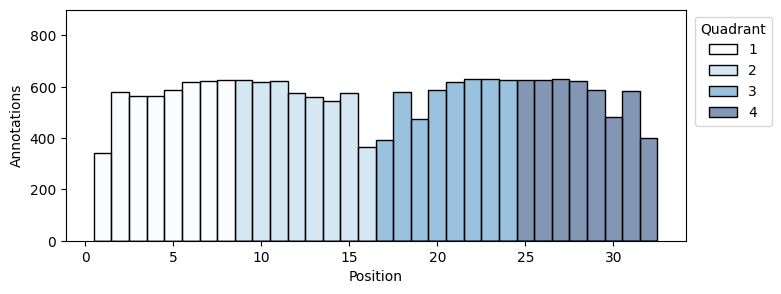

In [131]:
annotations_file_name = 'train_quadrant_enumeration_cropped.parquet'
annotations_file = os.path.join(image_dir, annotations_file_name)
df = pd.read_parquet(annotations_file)
print(image_dir)

# Add FDI positions, ADA positions and labels
fdi_fun = lambda r: np.int64(f'{r["quadrant"]}{r["pos"]}')
df = df.assign(fdi=df.apply(fdi_fun, axis=1))
df = df.assign(ada=df['fdi'].apply(lambda fdi: fdi2ada.get(fdi)))
display(df.head())

# Quick histogram to show distribution of teeth
fig, ax = plt.subplots(figsize=(8, 3))
ax = plot_hist(data=df, ax=ax)
ax.set(ylim=[0, 900], yticks=np.arange(0, 1000, 200))
hist_file_name = 'dentex_annotation_hist.png'
hist_file = os.path.join(data_dir, hist_file_name)
plt.savefig(hist_file, bbox_inches='tight')
plt.show()

### Show some images with bounding boxes ###

In [ ]:
display(df.head(2))
file_list = sorted(list(df['file_name'].unique()))

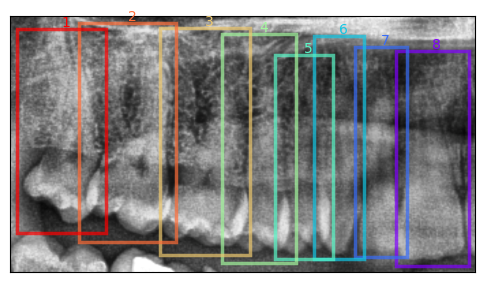

In [133]:
#for i in range(100):
file_name = np.random.choice(file_list, size=1, replace=False)[0]
file = os.path.join(image_dir, file_name)
output_file_name = f'{os.path.splitext(file_name)[0]}_boxes.png'
overlay_file = os.path.join(output_dir, output_file_name)
box_list = df.loc[df['file_name'] == file_name, 'bbox'].tolist()
seg_list = df.loc[df['file_name'] == file_name, 'segmentation'].tolist()
pos_list = df.loc[df['file_name'] == file_name, 'ada'].tolist()
im = ImageData().load_image(file)
im_eq = ImageData().hist_eq(im)
fig, ax = plt.subplots(figsize=(6, 5))
ax = show_image_with_boxes(image=im_eq, box_list=box_list, label_list=pos_list, ax=ax)
plt.savefig(overlay_file, bbox_inches='tight')
plt.show()

### Split the data into training, validation and testing ###

Total number of images:      2531
Total number of annotations: 18095

Train images:                2479
Train annotations:           17711

Val images:                  20
Val annotations:             149

Test images:                 32
Test annotations:            235

set()
set()
set()


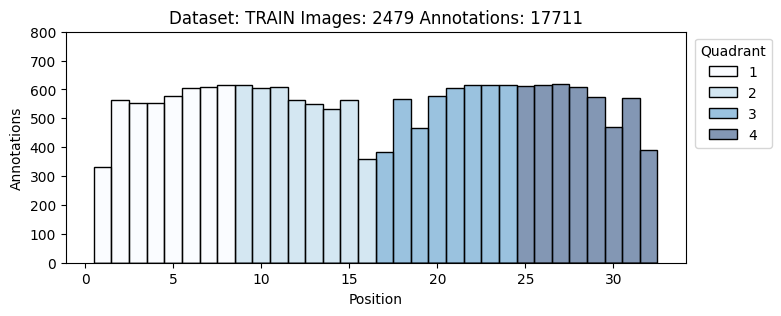

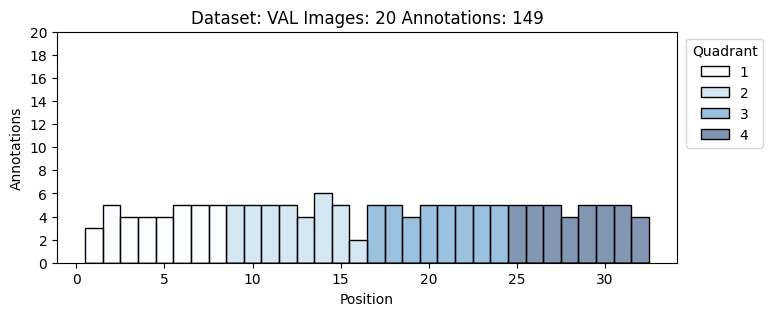

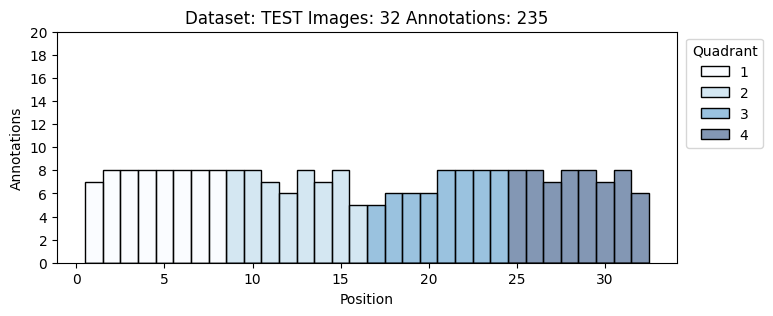

In [213]:
# Create test data set: remove the test images from the data set
image_list = sorted(list(df['file_name'].unique()))
df1 = val_test_split(data=df, 
                     label_col='quadrant', 
                     n_test_per_class=8, 
                     n_val_per_class=5,
                     random_state=113)

# Separate the test files from the rest of the images
test_files = sorted(list(df1.loc[df1['dataset'] == 'test', 'file_name'].unique()))
test_df = df.loc[df['file_name'].isin(test_files)].\
                assign(dset='test').\
                reset_index(drop=True)

# New data frame with the remaining image files
df1_remain = df1.loc[~df1['file_name'].isin(test_files)]
train_files = sorted(list(df1_remain.loc[df1_remain['dataset'] == 'train', 'file_name'].unique()))
val_files = sorted(list(df1_remain.loc[df1_remain['dataset'] == 'val', 'file_name'].unique()))

# Create data frames with the training and validation images
train_df = df.loc[(df['file_name'].isin(train_files)) & (~df['file_name'].isin(val_files))].\
                assign(dset='train').\
                reset_index(drop=True)

val_df = df.loc[df['file_name'].isin(val_files)].\
                assign(dset='val').\
                reset_index(drop=True)

split_df = pd.concat([train_df, val_df, test_df], axis=0, ignore_index=True)

# Check the overlap between the data sets
print(f'Total number of images:      {len(split_df['file_name'].unique())}')
print(f'Total number of annotations: {split_df.shape[0]}')
print()
train_df = split_df.loc[split_df['dset'] == 'train']
train_images = train_df['file_name'].unique()
print(f'Train images:                {len(train_images)}')
print(f'Train annotations:           {train_df.shape[0]}')
print()
val_df = split_df.loc[split_df['dset'] == 'val']
val_images = val_df['file_name'].unique()
print(f'Val images:                  {len(val_images)}')
print(f'Val annotations:             {val_df.shape[0]}')
print()
test_df = split_df.loc[split_df['dset'] == 'test']
test_images = test_df['file_name'].unique()
print(f'Test images:                 {len(test_images)}')
print(f'Test annotations:            {test_df.shape[0]}')

# Check image overlap
print()
print(set(train_images).intersection(test_images))
print(set(train_images).intersection(val_images))
print(set(test_images).intersection(val_images))

# Show the histograms for the different data sets with position distributions
dset_list = ['train', 'val', 'test']
figsize = (8, 3)
for dset in dset_list:
    dset_df = split_df.loc[split_df['dset'] == dset]
    n_images = len(dset_df['file_name'].unique())
    n = dset_df.shape[0]
    fig, ax = plt.subplots(figsize=figsize)
    ax = plot_hist(data=dset_df, ax=ax)
    if dset == 'train':
        ax.set(ylim=[0, 800], yticks=np.arange(0, 900, 100))
    else:
        ax.set(ylim=[0, 20], yticks=np.arange(0, 22, 2))
    ax.set(title=f'Dataset: {dset.upper()} Images: {n_images} Annotations: {n}')
    hist_file_name = f'dentex_annotation_hist_{dset}.png'
    hist_file = os.path.join(data_dir, hist_file_name)
    plt.savefig(hist_file, bbox_inches='tight')
    plt.show()

In [223]:
# Save the split file
# Get todays date
date_str = datetime.date.today().strftime('%y%m%d')
print(date_str)
split_name = f'train_split_{date_str}.parquet'
split_file = os.path.join(image_dir, split_name)
split_df.to_parquet(split_file)
print(split_file)

250223
/app/data/dentex_detection/quadrants/train_split_250223.parquet
